In [1]:
%load_ext lab_black
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, ReLU, LeakyReLU, GRU, Input, Concatenate
from keras.callbacks import EarlyStopping
from keras.initializers import glorot_uniform, orthogonal
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
data = pd.read_csv("../data/five_percent.csv").set_index("date")
nlp_predictions = pd.read_csv("../data/nlp_predictions.csv").set_index("date")
predictive = pd.read_csv("../data/predictive_features.csv").set_index("date")
predictive_index = predictive.index

target = "gas_price"
features = [col for col in data if col != target]

the_future = "2019-01-01"
train, test = data.loc[:the_future], data[the_future:]

In [5]:
scaler = MinMaxScaler()

train = scaler.fit_transform(train)
test = scaler.transform(test)
full_scaled = scaler.transform(data)

train = pd.DataFrame(train, columns=scaler.get_feature_names_out())
test = pd.DataFrame(test, columns=scaler.get_feature_names_out())
full_scaled = pd.DataFrame(full_scaled, columns=scaler.get_feature_names_out())

full_scaled["date"] = data.index
full_scaled = full_scaled.set_index("date")

In [6]:
predictive_scaler = MinMaxScaler()

predictive_scaler.fit(predictive.loc[:the_future])

predictive = pd.DataFrame(
    predictive_scaler.transform(predictive),
    columns=predictive_scaler.get_feature_names_out(),
)

predictive["date"] = predictive_index
predictive = predictive.set_index("date")

In [7]:
WINDOW = 52
FORECAST = 1

In [8]:
def data_windower(data, target, window=10, forecast=10):
    x_windowed = []
    y_forecasted = []
    for i in range(window, len(data) - forecast):
        x_windowed.append(data.iloc[i - window : i].values)
        y_forecasted.append(data[target].iloc[i : i + forecast].values)

    return x_windowed, y_forecasted


X_train, y_train = data_windower(train, "gas_price", window=WINDOW, forecast=FORECAST)

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

In [9]:
rnn = Sequential(
    [
        GRU(
            500,
            return_sequences=True,
            # recurrent_regularizer="l2",
            recurrent_initializer=orthogonal(seed=42),
            # kernel_regularizer="l2",
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            # recurrent_regularizer="l2",
            recurrent_initializer=orthogonal(seed=42),
            # kernel_regularizer="l2",
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            # recurrent_regularizer="l2",
            recurrent_initializer=orthogonal(seed=42),
            # kernel_regularizer="l2",
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            # recurrent_regularizer="l2",
            recurrent_initializer=orthogonal(seed=42),
            # kernel_regularizer="l2",
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            # recurrent_regularizer="l2",
            recurrent_initializer=orthogonal(seed=42),
            # kernel_regularizer="l2",
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            # recurrent_regularizer="l2",
            recurrent_initializer=orthogonal(seed=42),
            # kernel_regularizer="l2",
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            # recurrent_regularizer="l2",
            recurrent_initializer=orthogonal(seed=42),
            # kernel_regularizer="l2",
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            # recurrent_regularizer="l2",
            recurrent_initializer=orthogonal(seed=42),
            # kernel_regularizer="l2",
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=False,
            # recurrent_regularizer="l2",
            recurrent_initializer=orthogonal(seed=42),
            # kernel_regularizer="l2",
            kernel_initializer=glorot_uniform(seed=42),
        ),
        Dense(256, kernel_initializer=glorot_uniform(seed=42)),
        ReLU(),
        Dense(FORECAST, kernel_initializer=glorot_uniform(seed=42)),
    ]
)

optimizer = Adam(learning_rate=1e-4, amsgrad=True)

rnn.compile(loss="mse", optimizer=optimizer)

history = rnn.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
)

Epoch 1/1000
39/39 [==============================] - 11s 58ms/step - loss: 0.0334
Epoch 2/1000
39/39 [==============================] - 2s 58ms/step - loss: 0.0080
Epoch 3/1000
39/39 [==============================] - 2s 58ms/step - loss: 0.0057
Epoch 4/1000
39/39 [==============================] - 2s 58ms/step - loss: 0.0044
Epoch 5/1000
39/39 [==============================] - 2s 58ms/step - loss: 0.0033
Epoch 6/1000
39/39 [==============================] - 2s 58ms/step - loss: 0.0033
Epoch 7/1000
39/39 [==============================] - 2s 58ms/step - loss: 0.0035
Epoch 8/1000
39/39 [==============================] - 2s 58ms/step - loss: 0.0024
Epoch 9/1000
39/39 [==============================] - 2s 58ms/step - loss: 0.0022
Epoch 10/1000
39/39 [==============================] - 2s 58ms/step - loss: 0.0016
Epoch 11/1000
39/39 [==============================] - 2s 58ms/step - loss: 0.0018
Epoch 12/1000
39/39 [==============================] - 2s 58ms/step - loss: 0.0013
Epoch 13/100

In [10]:
train_pred = rnn.predict(X_train)

39/39 [==============================] - 2s 20ms/step


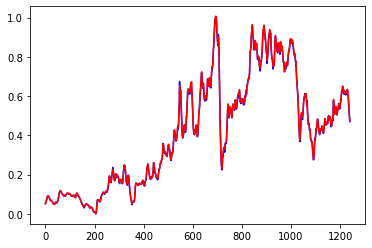

In [11]:
true_plot = y_train[:, -1]
pred_plot = train_pred[:, -1]

plt.plot(true_plot, color="blue")
plt.plot(pred_plot, color="red")

5/5 [==============================] - 0s 21ms/step


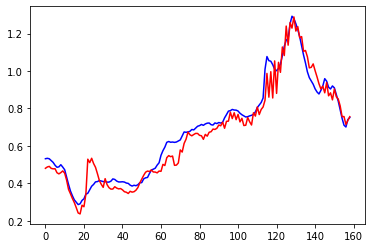

In [12]:
X_test, y_test = data_windower(test, "gas_price", window=WINDOW, forecast=FORECAST)

X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

test_pred = rnn.predict(X_test)

true_plot = y_test[:, -1]
pred_plot = test_pred[:, -1]

plt.plot(true_plot, color="blue")
plt.plot(pred_plot, color="red")

In [13]:
target = "gas_price"
rnn_features = data.columns
supplemental_features = list(predictive.columns) + list(nlp_predictions.columns)

merged_data = pd.concat(
    [full_scaled, predictive, nlp_predictions], join="inner", axis=1
)

merged_data

,zeta_0,zeta_1,zeta_2,zeta_3,zeta_4,zeta_5,zeta_6,zeta_7,zeta_8,zeta_9,...,zeta_24,zeta_25,zeta_26,zeta_27,zeta_28,gas_price,short_linear_projection,long_linear_projection,arima,nlp_label
date,,,,,,,,,,,,,,,,,,,,,
2005-02-28,0.470031,0.254887,0.372764,0.590353,0.369454,0.533583,0.303406,0.498744,0.522320,0.464859,...,0.461847,0.472076,0.099040,0.457345,0.338077,0.310634,0.313309,0.308254,0.319321,0.000000
2005-03-07,0.458451,0.164667,0.235700,0.622465,0.286955,0.574743,0.252201,0.549003,0.522164,0.485924,...,0.605456,0.345130,0.149071,0.623456,0.469286,0.317164,0.324091,0.316295,0.361845,0.000000
2005-04-11,0.467691,0.141435,0.256562,0.556270,0.318399,0.402343,0.528532,0.558085,0.515809,0.420104,...,0.399773,0.480783,0.114450,0.327785,0.448578,0.407027,0.426371,0.412412,0.389581,0.000000
2005-04-25,0.460905,0.231245,0.271062,0.457660,0.382413,0.448892,0.607299,0.562214,0.493958,0.366812,...,0.246624,0.609113,0.293086,0.234603,0.409581,0.413868,0.400801,0.418098,0.384878,1.000000
2005-05-09,0.469537,0.268725,0.339197,0.410571,0.378610,0.313665,0.737834,0.578678,0.507836,0.409543,...,0.211890,0.590176,0.427177,0.348320,0.419429,0.412935,0.411892,0.417212,0.409581,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.110582,0.356244,-0.085174,-0.217410,0.675838,0.465971,0.229828,0.434257,0.573159,0.600270,...,0.398758,0.376000,0.223081,0.367571,0.464694,0.710510,0.670672,0.675268,0.617414,-0.133333
2023-01-02,0.110659,0.394549,-0.113797,-0.165376,0.650346,0.455366,0.245122,0.417374,0.568288,0.611532,...,0.363258,0.582881,0.100679,0.169093,0.438685,0.700871,0.688232,0.666188,0.606836,-0.056738
2023-01-09,0.109476,0.404027,-0.142346,-0.116197,0.611711,0.445960,0.245803,0.414374,0.580693,0.628223,...,0.521457,0.376708,0.267337,0.376106,0.459023,0.740672,0.776648,0.712382,0.618779,-0.035971


In [14]:
X_rnn, y = data_windower(
    merged_data[rnn_features], target, window=WINDOW, forecast=FORECAST
)

index_of_the_future = len(merged_data.loc[:the_future]) - WINDOW

X_rnn_train = tf.convert_to_tensor(X_rnn[:index_of_the_future])
X_rnn_test = tf.convert_to_tensor(X_rnn[index_of_the_future:])

X_sup_train = tf.convert_to_tensor(
    merged_data[supplemental_features].iloc[WINDOW:].loc[:the_future]
)
X_sup_test = tf.convert_to_tensor(
    merged_data[supplemental_features].loc[the_future:].iloc[:-1]
)

y_train = tf.convert_to_tensor(y[:index_of_the_future])
y_test = tf.convert_to_tensor(y[index_of_the_future:])

print(X_rnn_train.shape, X_sup_train.shape)
print(X_rnn_test.shape, X_sup_test.shape)

(307, 52, 30) (307, 4)
(211, 52, 30) (211, 4)


In [15]:
rnn_input = Input(
    shape=(WINDOW, len(rnn_features)),
    name="rnn_input",
)
supplemental_input = Input(
    shape=(len(supplemental_features),), name="supplemental_input"
)

rnn_pred = rnn(rnn_input)

merged = Concatenate()([rnn_pred, supplemental_input])

dnn0 = Dense(256, activation="relu")(merged)
dnn1 = Dense(128, activation="relu")(dnn0)
dnn2 = Dense(64, activation="relu")(dnn1)
output = Dense(1)(dnn2)

model = keras.Model(inputs=[rnn_input, supplemental_input], outputs=[output])

In [16]:
model.compile(loss="mse", optimizer="adam")
model.fit(
    {"rnn_input": X_rnn_train, "supplemental_input": X_sup_train},
    y_train,
    epochs=1000,
    batch_size=32,
)

Epoch 1/1000
10/10 [==============================] - 10s 60ms/step - loss: 0.2018
Epoch 2/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0158
Epoch 3/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0064
Epoch 4/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0023
Epoch 5/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0011
Epoch 6/1000
10/10 [==============================] - 1s 57ms/step - loss: 5.6945e-04
Epoch 7/1000
10/10 [==============================] - 1s 57ms/step - loss: 3.2317e-04
Epoch 8/1000
10/10 [==============================] - 1s 57ms/step - loss: 2.3670e-04
Epoch 9/1000
10/10 [==============================] - 1s 57ms/step - loss: 2.4537e-04
Epoch 10/1000
10/10 [==============================] - 1s 57ms/step - loss: 1.9732e-04
Epoch 11/1000
10/10 [==============================] - 1s 57ms/step - loss: 2.0890e-04
Epoch 12/1000
10/10 [==============================] - 1s 57ms/step - l

7/7 [==============================] - 2s 18ms/step


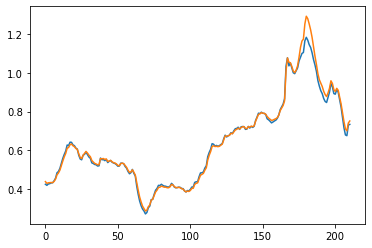

In [17]:
y_pred = model.predict({"rnn_input": X_rnn_test, "supplemental_input": X_sup_test})

plt.plot(y_pred)
plt.plot(y_test)

In [18]:
X_rnn_test.shape

TensorShape([211, 52, 30])

In [19]:
X_sup_test.shape

TensorShape([211, 4])

In [20]:
np.min(y)

0.2751865671641792